# Step 3 - Generate Sentence Vectors

This script is to generate sentence vectors using fasttext pretrained model and run a simple test.

Prerequisites:
    To run this script, a fasttext pretrained model is needed. 
    Download link: https://fasttext.cc/docs/en/english-vectors.html
Input: 
    1. database file
    2. answer file
Output:
    1. Sentence embedding files in .npy with the same name as database file
    2. A json file (same name as the database file but with additional text '_results' in it) including all search results

In [1]:
%pylab inline
import os
import json
from PIL import Image
import utilities as util
import vectors

Populating the interactive namespace from numpy and matplotlib


In [42]:
"""
Make sure these variables are correctly set.
model: file path to pretrained model
database_file: file path to database file generated from previous steps
inquiry_file: a file with some example inquiries
moving_average_filter_enabled: whether or not to apply filter to sentence vectors. 
                               A separate numpy file will be generated with '_ma' in the file name
window_size: window size for the filter
"""

model = './visualization/backend/fasttext/wiki.en.bin' 
database_file = './visualization/backend/datasource/Life Is Strange 1/output/lifeisstrange_w_img_top3keywords.json'
inquiry_file = './visualization/backend/datasource/Life Is Strange 1/output/correct_answers.json'
enable_caption = True
enable_image_keyword = True
moving_average_filter_enabled = True
window_size = 9


In [3]:
%%time

word_embeddings = vectors.Vectors(model)
word_embeddings.load_word_vectors(mode='fasttext')
print(f'vector_size = {word_embeddings.vector_size}')

loading fasttext vectors
vector_size = 300
CPU times: user 6min 55s, sys: 1min 18s, total: 8min 13s
Wall time: 11min 22s


In [43]:
"""
get sentence vectors
"""
emb_foldername = "embeddings"
emb_foldername += "_img" if enable_image_keyword else ""
emb_foldername += "_cap" if enable_caption else ""

ind_dict = dict()
emb_dict_folder = os.path.dirname(database_file)
db_filename = os.path.splitext(os.path.basename(database_file))[0]
emb_dict_file = os.path.join(emb_dict_folder, db_filename + '_emb.json')
print(emb_dict_file)

sentence_vectors = np.empty((0, word_embeddings.vector_size))
sentence_vectors_filtered = np.empty((0, word_embeddings.vector_size))

with open(database_file, 'r') as input_file, \
    open(emb_dict_file, 'w') as output_file:
    json_str = input_file.read()
    database = json.loads(json_str)
    sentence_id = 0
    for file_idx, data in database.items():
        img_sessions = data['screenshots']['image_info']
        cap_sessions = data['captions']['captions']
        img_folder = data['screenshots']['image_folder']
        
        sentences = []
        for session_id, img_session in img_sessions.items():
            cap_text = cap_sessions[session_id]['text']
            for frame_id, frame_info in img_session['frames'].items():
                frame_keywords = ''
                if 'image_keywords' in frame_info.keys():
                    frame_keywords = frame_info['image_keywords']
                    frame_keywords = frame_keywords.replace('_', ' ')
                # print(f'{cap_text}, {frame_keywords}')    
                text_lst = []
                if enable_caption: text_lst.append(cap_text)
                if enable_image_keyword: text_lst.append(frame_keywords)
                    
                sentences.append(' '.join(text_lst))
                ind_dict[sentence_id] = (file_idx, session_id, frame_id)
                sentence_id += 1
        # print(f'sentences: {sentences}')            
        vectors = word_embeddings.generate_sentence_vectors(sentences) 
        sentence_vectors = np.concatenate((sentence_vectors, vectors))
        # print(sentence_vectors)
        # save vectors 
        img_folder = img_folder.replace('\\', '/') 
        emb_folder = os.path.join(os.path.dirname(img_folder), emb_foldername)
        print(f'img_folder: {img_folder}')
        if not os.path.exists(emb_folder):
            os.makedirs(emb_folder)
        embedding_file = os.path.join(emb_folder, 'embeddings')
        print(f'embedding shape: {vectors.shape}, embedding_file: {embedding_file}')
        np.save(embedding_file, vectors)
        
        # apply moving average filter
        if moving_average_filter_enabled:
            vector_filtered = util.moving_average(vectors, window_size)
            sentence_vectors_filtered = np.concatenate((sentence_vectors_filtered, vector_filtered))
            emb_folder = os.path.join(os.path.dirname(img_folder), emb_foldername + '_ma' + str(window_size))
            if not os.path.exists(emb_folder):
                os.makedirs(emb_folder)
            embedding_file = os.path.join(emb_folder, 'embeddings')
            np.save(embedding_file, vector_filtered)   
        
    if len(ind_dict.keys()) != vectors.shape[0]:
        print(f'number of sentences: {len(ind_dict.keys())}')

    json.dump(ind_dict, output_file, sort_keys=False, indent=4)


./visualization/backend/datasource/Life Is Strange 1/output/lifeisstrange_w_img_top3keywords_emb.json
img_folder: ./visualization/backend/datasource/Life Is Strange 1/output/Episode_1_Chrysalis/screenshots
embedding shape: (3809, 300), embedding_file: ./visualization/backend/datasource/Life Is Strange 1/output/Episode_1_Chrysalis/embeddings_img_cap/embeddings
img_folder: ./visualization/backend/datasource/Life Is Strange 1/output/Episode_2_Out_of_Time/screenshots
embedding shape: (4615, 300), embedding_file: ./visualization/backend/datasource/Life Is Strange 1/output/Episode_2_Out_of_Time/embeddings_img_cap/embeddings
img_folder: ./visualization/backend/datasource/Life Is Strange 1/output/Episode_3_Chaos_Theory/screenshots
embedding shape: (4406, 300), embedding_file: ./visualization/backend/datasource/Life Is Strange 1/output/Episode_3_Chaos_Theory/embeddings_img_cap/embeddings
img_folder: ./visualization/backend/datasource/Life Is Strange 1/output/Episode_4_Dark_Room/screenshots
embe

In [44]:
%%time
"""
Run test cases given a answer file including the following tests:

Testcase 1: Finding the most relevant sentences given a source sentence that appears in the real dialogues extracted. 
    This is to check whether the word embedding is correctly calculated. 
    
Testcase 2: Finding the most relevant sentences given a random combination of words. 
    This is to test whether the search can find semantically similar dialogues.
    
Testcase 3: Finding relevant images given some keywords. 
    This is to test whether the system can return useful results using the combination of sentence embeddings 
    and image keywords.

Results will be saved to a json file.
"""

if moving_average_filter_enabled:
    print(f'Moving average filter applied with window size {window_size}')
    result_file = os.path.join(emb_dict_folder, emb_foldername + '_ma' + str(window_size) + '_results.json')
    vec_pool = sentence_vectors_filtered
else:
    vec_pool = sentence_vectors
    result_file = os.path.join(emb_dict_folder, emb_foldername + '_results.json')

    
with open(result_file, 'w+') as rst_f, open(inquiry_file, 'r+') as inq_f:
    inquiry_database = json.loads(inq_f.read())
    result_str = rst_f.read()
    
    if len(result_str) > 0:
        result_data = json.loads(result_str)
    else:
        result_data = {}
    
    # sentence_dir = ['find the keys']
    sentence_dir = inquiry_database.keys()    
    
    for src_sentence_id, src_sentence in enumerate(sentence_dir):
        # get similar vectors, only used for bin
        print(f'User Inquiry: {src_sentence}')
        vec_sen = word_embeddings.get_sentence_vector(src_sentence, in_vocabulary = True) 
        if enable_caption or enable_image_keyword:
            neighbours = word_embeddings.find_nearest_neighbour(vec_sen, vec_pool)
        else:
            neighbours = util.random_neighbours(vec_sen, vec_pool)
        result_data[src_sentence] = []
        for top_n, (nb_id, distance) in enumerate(neighbours):
            file_id = ind_dict[nb_id][0]
            session_id = ind_dict[nb_id][1]
            key = ind_dict[nb_id][2]
            result_data[src_sentence].append({'file_id': file_id, 'session_id': session_id, 'frame_id': key, 'distance': distance})
    print(f'Results saved to {result_file}')
    json.dump(result_data, rst_f, indent=4)


Moving average filter applied with window size 9
User Inquiry: deduction scene
User Inquiry: rewind prompt
User Inquiry: Max fire alarm Chloe Rescue
User Inquiry: Butterfly Bucket
User Inquiry: Nathan Gun Chloe
User Inquiry: danger gun
User Inquiry: Time Freeze Kate Birds
User Inquiry: Kate Rooftop Max
User Inquiry: storm lightening
User Inquiry: storm cliff tornado
User Inquiry: toilet gun
User Inquiry: selfie classroom
User Inquiry: Max gallery
User Inquiry: Kate hospital
User Inquiry: Restaurant Jukebox
User Inquiry: swimming pool
User Inquiry: railway train stuck
User Inquiry: beacon
User Inquiry: sea sunset
User Inquiry: jukebox cafe
User Inquiry: jump okay okay I'm right here Kate
User Inquiry: Kate she did try to kill herself all
User Inquiry: Kate tried to kill herself
User Inquiry: Warren's new car
User Inquiry: Chloe Smoking
User Inquiry: Spirit Doe
User Inquiry: Jump
Results saved to ./visualization/backend/datasource/Life Is Strange 1/output/embeddings_img_cap_ma9_results.j

User Inquiry: daughter got shot dead
top_n: 0, distance: -0.0017715660548431123, file_id: 0, session_id: 305, frame_id: 43062, captions: on him was that before or after he left, Image keywords: bulletproof_vest cash_machine turnstile
top_n: 1, distance: -0.0017715660548431123, file_id: 0, session_id: 1688, frame_id: 285036, captions: Helly where is she, Image keywords: barbershop prison cellular_telephone
top_n: 2, distance: -0.0017715660548431123, file_id: 0, session_id: 1110, frame_id: 181051, captions: , Image keywords: sliding_door safe shower_curtain
top_n: 3, distance: -0.0017715660548431123, file_id: 0, session_id: 2026, frame_id: 355690, captions: , Image keywords: web_site menu
top_n: 4, distance: -0.0017715660548431123, file_id: 0, session_id: 1638, frame_id: 270903, captions: , Image keywords: jean swing cellular_telephone
top_n: 5, distance: -0.0017715660548431123, file_id: 0, session_id: 681, frame_id: 101294, captions: anywhere but here the hallways come on, Image keyword

top_n: 10, distance: -0.008525457842397364, file_id: 0, session_id: 1810, frame_id: 317812, captions: , Image keywords: schipperke suspension_bridge guillotine
top_n: 11, distance: -0.008525457842397364, file_id: 0, session_id: 394, frame_id: 54631, captions: you what is out there I get it, Image keywords: gong barrel shield
top_n: 12, distance: -0.008525457842397364, file_id: 0, session_id: 1159, frame_id: 191008, captions: what about you those things out there, Image keywords: window_screen sliding_door book_jacket
top_n: 13, distance: -0.008525457842397364, file_id: 0, session_id: 238, frame_id: 35088, captions: where's our guns I can't just give me a, Image keywords: sax prison marimba
top_n: 14, distance: -0.008525457842397364, file_id: 0, session_id: 705, frame_id: 106862, captions: who the hell's Frank he was my partner, Image keywords: lab_coat marimba trench_coat
top_n: 15, distance: -0.008525457842397364, file_id: 0, session_id: 1646, frame_id: 278395, captions: , Image keywo

User Inquiry: brother tommy
top_n: 0, distance: 0.09710190626722212, file_id: 0, session_id: 778, frame_id: 116302, captions: kids whoa how how the hell he even walk, Image keywords: seat_belt ski bow
top_n: 1, distance: 0.09710190626722212, file_id: 0, session_id: 1531, frame_id: 248388, captions: tell me what to do you gotta get up, Image keywords: notebook printer photocopier
top_n: 2, distance: 0.09710190626722212, file_id: 0, session_id: 1110, frame_id: 182467, captions: , Image keywords: patio cannon boathouse
top_n: 3, distance: 0.09710190626722212, file_id: 0, session_id: 1449, frame_id: 227614, captions: sounds like robbers stay with the horse, Image keywords: prison yurt chainlink_fence
top_n: 4, distance: 0.09710190626722212, file_id: 0, session_id: 907, frame_id: 147734, captions: Oh ma'am let's  get to that bridge, Image keywords: fur_coat wardrobe cash_machine
top_n: 5, distance: 0.09710190626722212, file_id: 0, session_id: 863, frame_id: 134990, captions: fire you're gon

top_n: 10, distance: -0.02204314680149447, file_id: 0, session_id: 2026, frame_id: 353035, captions: , Image keywords: web_site menu
top_n: 11, distance: -0.02204314680149447, file_id: 0, session_id: 1686, frame_id: 283943, captions: tiny pieces see in the morning le, Image keywords: crutch jean accordion
top_n: 12, distance: -0.02204314680149447, file_id: 0, session_id: 829, frame_id: 129134, captions: you down finish it I got it nicely done, Image keywords: soccer_ball barrel planetarium
top_n: 13, distance: -0.02204314680149447, file_id: 0, session_id: 519, frame_id: 77490, captions: smoke you think that's him there's no, Image keywords: guillotine crane prison
top_n: 14, distance: -0.02204314680149447, file_id: 0, session_id: 1652, frame_id: 279484, captions: is it it's dear miss mhmm and helping on, Image keywords: pajama suit cloak
top_n: 15, distance: -0.02204314680149447, file_id: 0, session_id: 322, frame_id: 45450, captions: your watch is broken, Image keywords: military_unif

User Inquiry: Rabbit
top_n: 0, distance: 0.027445478984916845, file_id: 0, session_id: 1522, frame_id: 244134, captions: then fucking walk come on, Image keywords: cash_machine pay-phone
top_n: 1, distance: 0.027445478984916845, file_id: 0, session_id: 423, frame_id: 62230, captions: I'll make my way around, Image keywords: lumbermill wreck vault
top_n: 2, distance: 0.027445478984916845, file_id: 0, session_id: 344, frame_id: 48322, captions: something something like that how long, Image keywords: guillotine torch cloak
top_n: 3, distance: 0.027445478984916845, file_id: 0, session_id: 503, frame_id: 75960, captions: it's kind of cool why don't you just, Image keywords: cliff flagpole fur_coat
top_n: 4, distance: 0.027445478984916845, file_id: 0, session_id: 375, frame_id: 52934, captions: , Image keywords: prison spider_monkey vault
top_n: 5, distance: 0.027445478984916845, file_id: 0, session_id: 1465, frame_id: 233163, captions: come on kiddo give me your hand Thanks, Image keywords:

top_n: 10, distance: -0.044582267979243854, file_id: 0, session_id: 763, frame_id: 114658, captions: here is not a bad read only one problem, Image keywords: seat_belt limousine
top_n: 11, distance: -0.044582267979243854, file_id: 0, session_id: 267, frame_id: 38579, captions: here the military's been wiping you guys, Image keywords: bookshop fur_coat tobacco_shop
top_n: 12, distance: -0.044582267979243854, file_id: 0, session_id: 1799, frame_id: 315708, captions: oh no I could get us up there Bailey get, Image keywords: barrow ashcan gasmask
top_n: 13, distance: -0.044582267979243854, file_id: 0, session_id: 1671, frame_id: 281541, captions: now I think it's your turn it's the only, Image keywords: prison turnstile
top_n: 14, distance: -0.044582267979243854, file_id: 0, session_id: 98, frame_id: 13167, captions: we could just backtrack come on people, Image keywords: passenger_car limousine minibus
top_n: 15, distance: -0.044582267979243854, file_id: 0, session_id: 1714, frame_id: 294

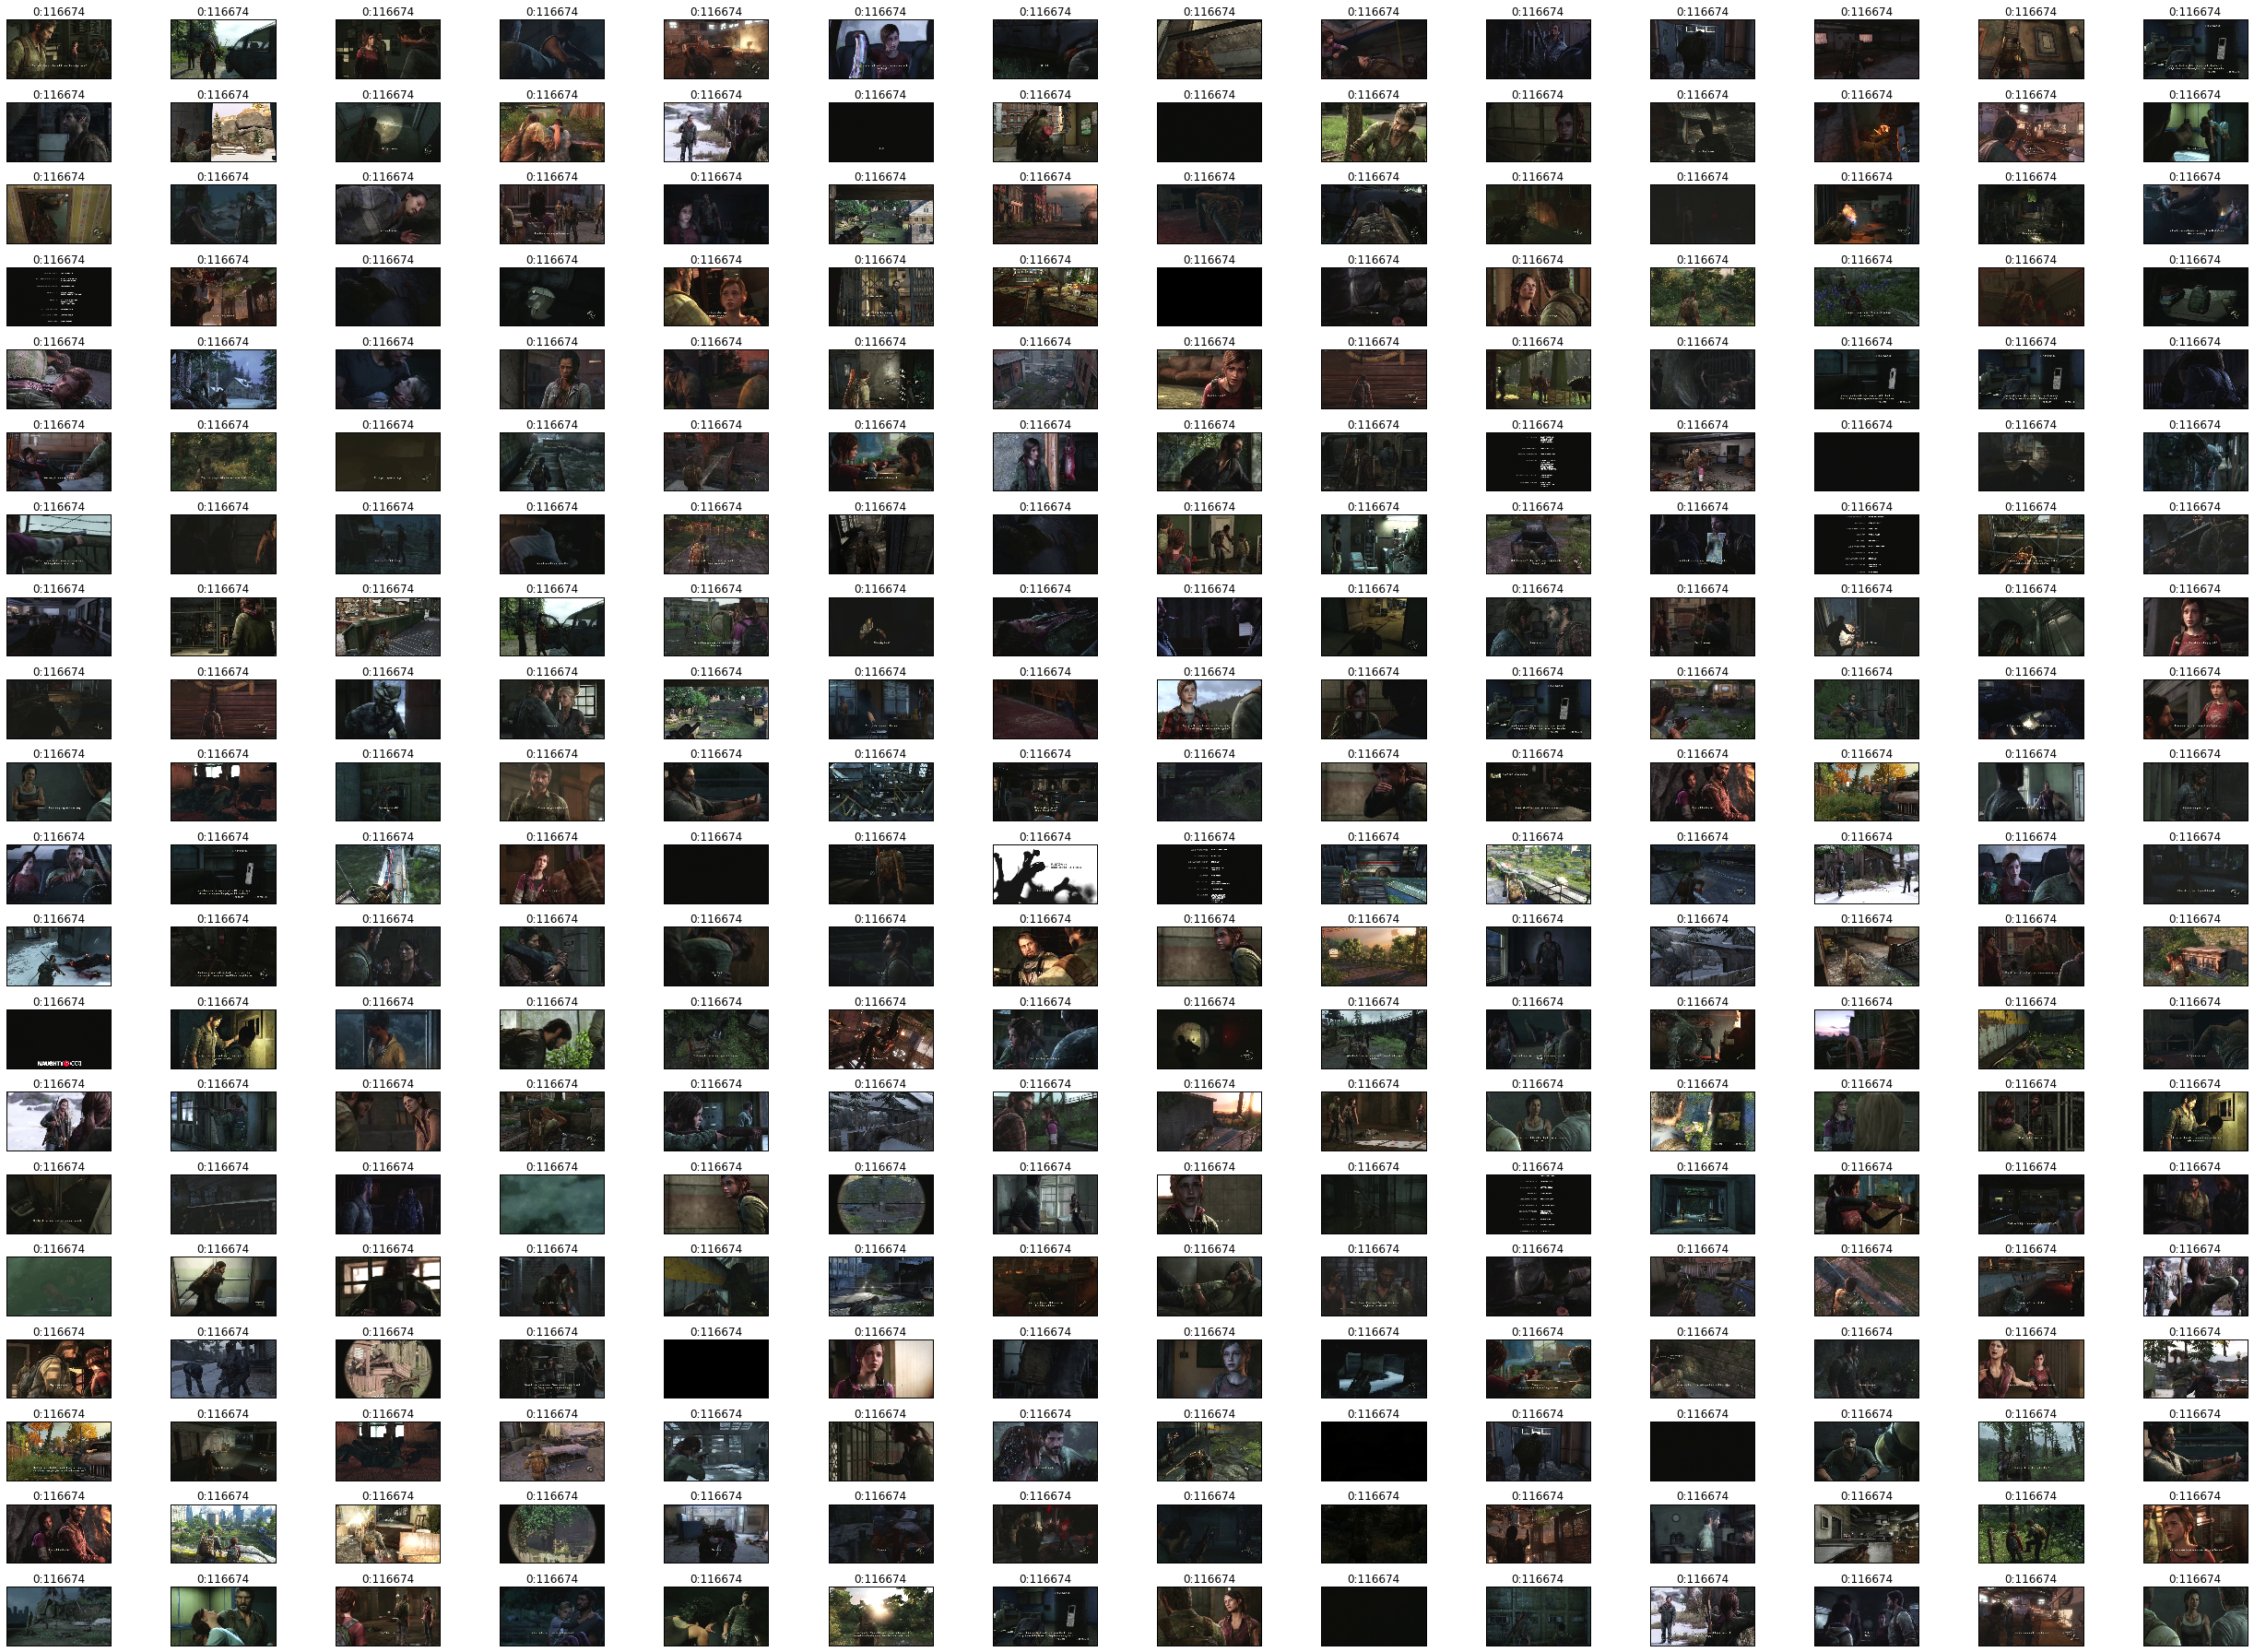

In [11]:
"""
Print out search results. 
To display only one result, just comment out line 7 and use line 6 instead, and 
replace that string with another inquiry listed in the answer file.
"""
# sentence_dir = ["daughter got shot dead"]
sentence_dir = inquiry_database.keys()
top_n_neighbours = 20
if len(sentence_dir) > 1:
    fig, axes = plt.subplots(top_n_neighbours, len(sentence_dir), figsize=(35, 25), subplot_kw={'xticks': [], 'yticks': []})

for src_sentence_id, src_sentence in enumerate(sentence_dir):
    print(f'User Inquiry: {src_sentence}')
    for top_n, rst in enumerate(result_data[src_sentence][:top_n_neighbours]):
        distance = rst['distance']
        file_id = rst['file_id']
        session_id = rst['session_id']
        img_folder = database[file_id]['screenshots']['image_folder']
        img_sessions = database[file_id]['screenshots']['image_info']
        frame_id = rst['frame_id']
        img_file = img_sessions[session_id]['frames'][frame_id]['image_file']
        img_folder = img_folder.replace('\\', '/')
        img_file = os.path.join(img_folder, img_file)
        image = Image.open(img_file) 
        cap_text = database[file_id]['captions']['captions'][session_id]['text']
        img_keywords = ''
        if 'image_keywords' in img_sessions[session_id]['frames'][frame_id].keys():
            img_keywords = img_sessions[session_id]['frames'][frame_id]['image_keywords']
        print(f'top_n: {top_n}, distance: {distance}, file_id: {file_id}, session_id: {session_id}, frame_id: {frame_id}, captions: {cap_text}, Image keywords: {img_keywords}')
        
        title = f'{file_id}:{key}'
        if len(sentence_dir) > 1:
            axes[top_n][src_sentence_id].imshow(np.asarray(image))
            axes[top_n][src_sentence_id].set_title(title)
        else:
            plt.figure()
            plt.imshow(image)
    
if len(sentence_dir) > 1:
    fig.tight_layout()       
    plt.show()

In [77]:
vec_examples = []
example_file = './visualization/backend/datasource/The Last Of Us/output/example.json'
with open(example_file) as example:
    example_queries = json.loads(example.read()) 
    for query in example_queries:
        vector = word_embeddings.get_sentence_vector(query) 
        vec_examples.append(vector)
    np_file = example_file[0:example_file.rfind('.json')-1]
    np.save(np_file, vec_examples)  
    # validation
    vec_exmp = np.load(np_file + '.npy')
    print(vec_exmp.shape)

(21, 300)
